## Geospatial merging decisions

As mentioned in `1_Country shapefile debugging.ipynb` I opted to go for raster based merging with the polygons of each country's shapefile in the code in order to obtain total yields (both the Rain and Irrigated components, or in the case of grasses, C3grass and C4grass). 

However, there are many ways in which I could have calculated the geospatial merging. I considered the options below, and ultimately opted for the combination (Sum of total yields, no touching pixels) which had the highest correlation and lowest mean average different (MAD) in percentage points with the reference file.

### How to combine rain and irrigated components.

Below is an example of the CropRain, CropIrr and total Crop (CropRain+CropIrr) data overlayed for the United Arab Emirates. Without filling in NaN values for each band beforehand, any pixel with a NaN value would mean the loss of the yield value for the non-Nan value in one of the bands, as illustrated below.

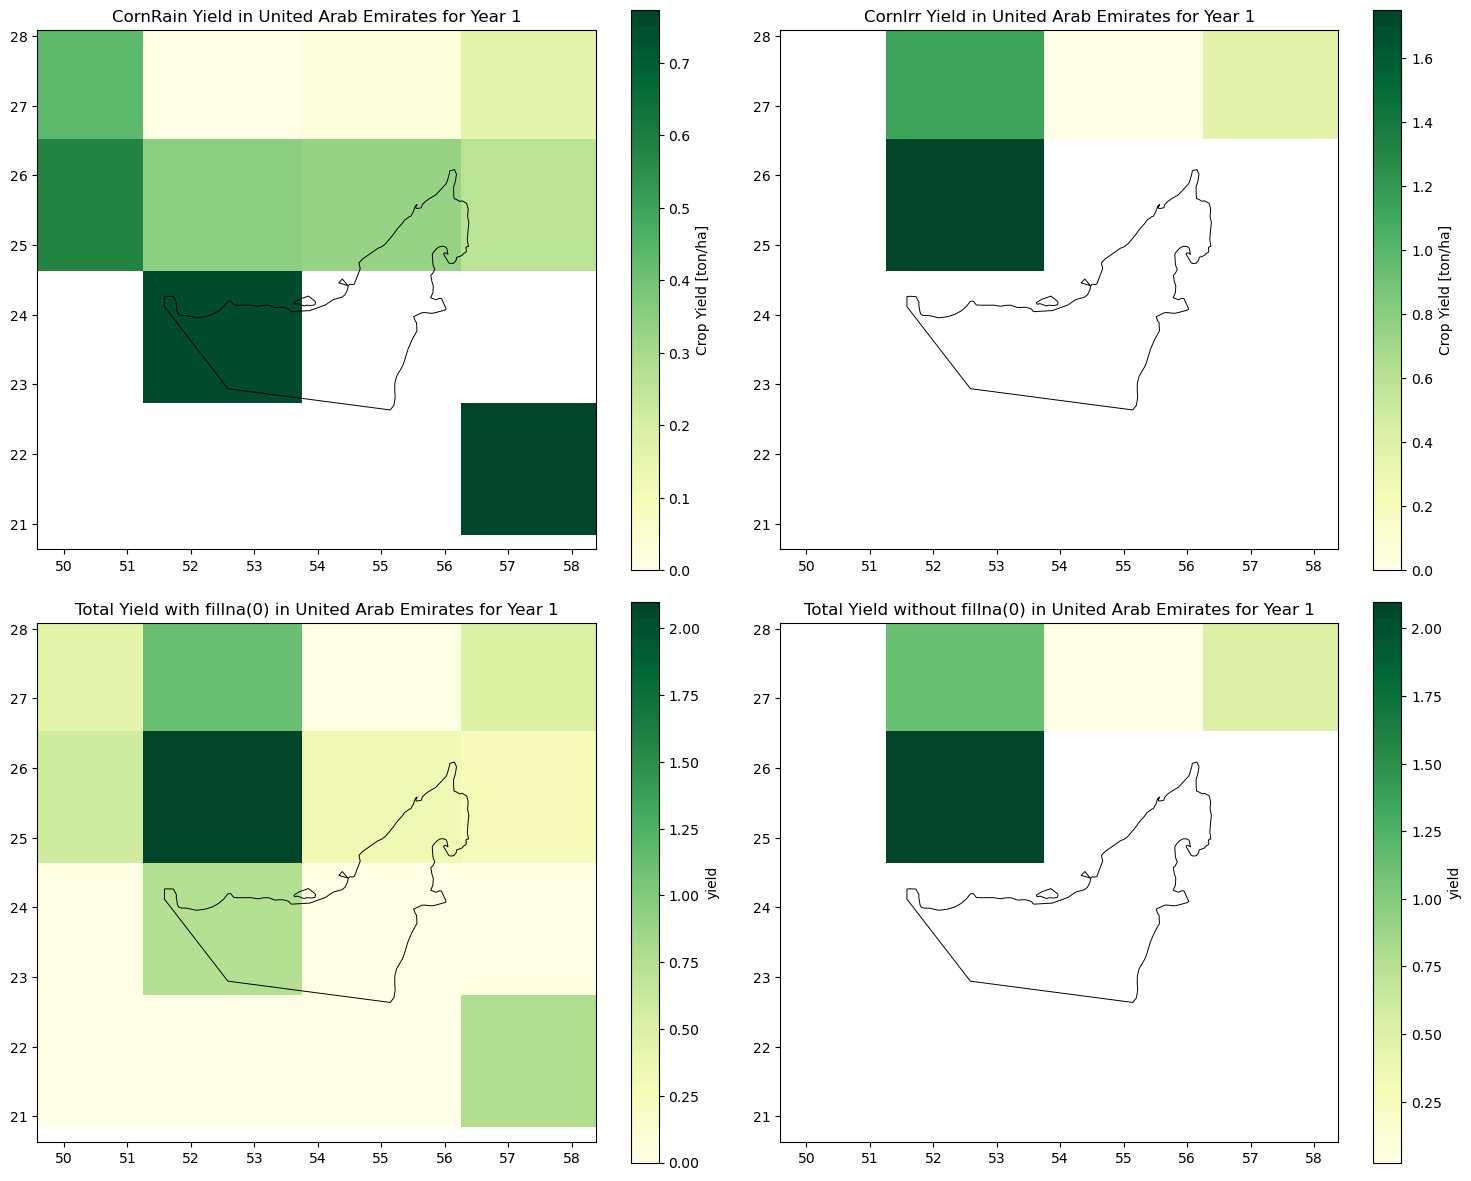

In [6]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# Parameters
country_name = 'United Arab Emirates'
crop_name = 'Corn'
raster_file_path = '../data/raw/Crop Yield/clm5_crop_2deg_cpl_nw_ur_150_07_0005-0019_yield_latlon_CLM5mask_6crops.nc'
shapefile_path = '../data/external/World_Countries__Generalized_/World_Countries__Generalized_.shp'
buffer_deg = 2  # Degrees to buffer around the country's bounding box

# Load the raster dataset
ds = xr.open_dataset(raster_file_path)

# Fix longitude values by converting from [0, 360] to [-180, 180]
ds = ds.assign_coords(lon=(((ds['lon'] + 180) % 360) - 180))

# Sort the dataset by longitude to ensure proper plotting
ds = ds.sortby('lon')

# Extract crop names from the 'crops' coordinate attribute
crop_names = ds['crops'].attrs['long_name'].split(',')

# Prepare crop names with 'Rain' and 'Irr' suffixes
rain_crop_name = crop_name + 'Rain'
irr_crop_name = crop_name + 'Irr'

if rain_crop_name not in crop_names or irr_crop_name not in crop_names:
    print(f"Crop names '{rain_crop_name}' or '{irr_crop_name}' not found in the dataset.")
    exit()

# Find the indices for rainfed and irrigated crops
rain_idx = crop_names.index(rain_crop_name)
irr_idx = crop_names.index(irr_crop_name)

# Extract yields for both rainfed and irrigated crops WITHOUT filling NaNs
rain_yield = ds['yield'].isel(crops=rain_idx)
irr_yield = ds['yield'].isel(crops=irr_idx)

# Sum rainfed and irrigated yields for the total yield WITH and WITHOUT fillna(0)
total_yield_with_fillna = rain_yield.fillna(0) + irr_yield.fillna(0)
total_yield_without_fillna = rain_yield + irr_yield

# Load the shapefile with geopandas
gdf = gpd.read_file(shapefile_path)

# Ensure the CRS is consistent (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Get the country geometry from GeoDataFrame
country = gdf[gdf['COUNTRY'] == country_name]
if country.empty:
    print(f"Country '{country_name}' not found in the dataset.")
    exit()

country_geometry = country.iloc[0].geometry
bbox = country_geometry.bounds  # (minx, miny, maxx, maxy)

# Apply buffer to the bounding box
lon_min, lat_min, lon_max, lat_max = bbox
lon_min -= buffer_deg
lon_max += buffer_deg
lat_min -= buffer_deg
lat_max += buffer_deg

# Apply the coordinate condition using 'where' and drop NaN values
condition = ((ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
             (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max))

rain_yield = rain_yield.where(condition, drop=True)
irr_yield = irr_yield.where(condition, drop=True)
total_yield_with_fillna = total_yield_with_fillna.where(condition, drop=True)
total_yield_without_fillna = total_yield_without_fillna.where(condition, drop=True)

# Extract the yield data for year 1 (index 0)
rain_yield_year = rain_yield.isel(time=0)
irr_yield_year = irr_yield.isel(time=0)
total_yield_with_fillna_year = total_yield_with_fillna.isel(time=0)
total_yield_without_fillna_year = total_yield_without_fillna.isel(time=0)

# Plot the yield data
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Flatten axs for easy indexing
axs = axs.flatten()

# Plot Rainfed yield
im0 = rain_yield_year.plot(ax=axs[0], cmap='YlGn', add_colorbar=True)
country.boundary.plot(ax=axs[0], edgecolor='black', linewidth=0.7)
axs[0].set_xlim(lon_min, lon_max)
axs[0].set_ylim(lat_min, lat_max)
axs[0].set_title(f'{rain_crop_name} Yield in {country_name} for Year 1')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

# Plot Irrigated yield
im1 = irr_yield_year.plot(ax=axs[1], cmap='YlGn', add_colorbar=True)
country.boundary.plot(ax=axs[1], edgecolor='black', linewidth=0.7)
axs[1].set_xlim(lon_min, lon_max)
axs[1].set_ylim(lat_min, lat_max)
axs[1].set_title(f'{irr_crop_name} Yield in {country_name} for Year 1')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Plot Total yield with fillna(0)
im2 = total_yield_with_fillna_year.plot(ax=axs[2], cmap='YlGn', add_colorbar=True)
country.boundary.plot(ax=axs[2], edgecolor='black', linewidth=0.7)
axs[2].set_xlim(lon_min, lon_max)
axs[2].set_ylim(lat_min, lat_max)
axs[2].set_title(f'Total Yield with fillna(0) in {country_name} for Year 1')
axs[2].set_xlabel('')
axs[2].set_ylabel('')

# Plot Total yield without fillna(0)
im3 = total_yield_without_fillna_year.plot(ax=axs[3], cmap='YlGn', add_colorbar=True)
country.boundary.plot(ax=axs[3], edgecolor='black', linewidth=0.7)
axs[3].set_xlim(lon_min, lon_max)
axs[3].set_ylim(lat_min, lat_max)
axs[3].set_title(f'Total Yield without fillna(0) in {country_name} for Year 1')
axs[3].set_xlabel('')
axs[3].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Save and show the figure
plt.savefig(f'{country_name}_{crop_name}_yield_year1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### EPSG 6933 for yield calculation

The rasters are in units of tons per hectare. Therefore, we can't simply add up the raster values for the total yield as in our previous block of code. However, the units aren't important so long as we convert them to a unit of total yield, rather than yield density, since we calculate percentage changes (i.e. units will cancel out).

So that we can treat the pixel values as "yield" rather than "yield density", I convert all rasters and country pologyons to `EPSG:6933` in `src/1_yield_change_calculation.py`, a cylindrical projection which means that all the raster pixels end up with the same area. This eliminates the need to calculate the total yields by multiplying each pixel value by its area, only to later divide it out when we calculate percentage changes. 

This choice of CRS has implications for which pixels end up overlapping with each country, as shown below.

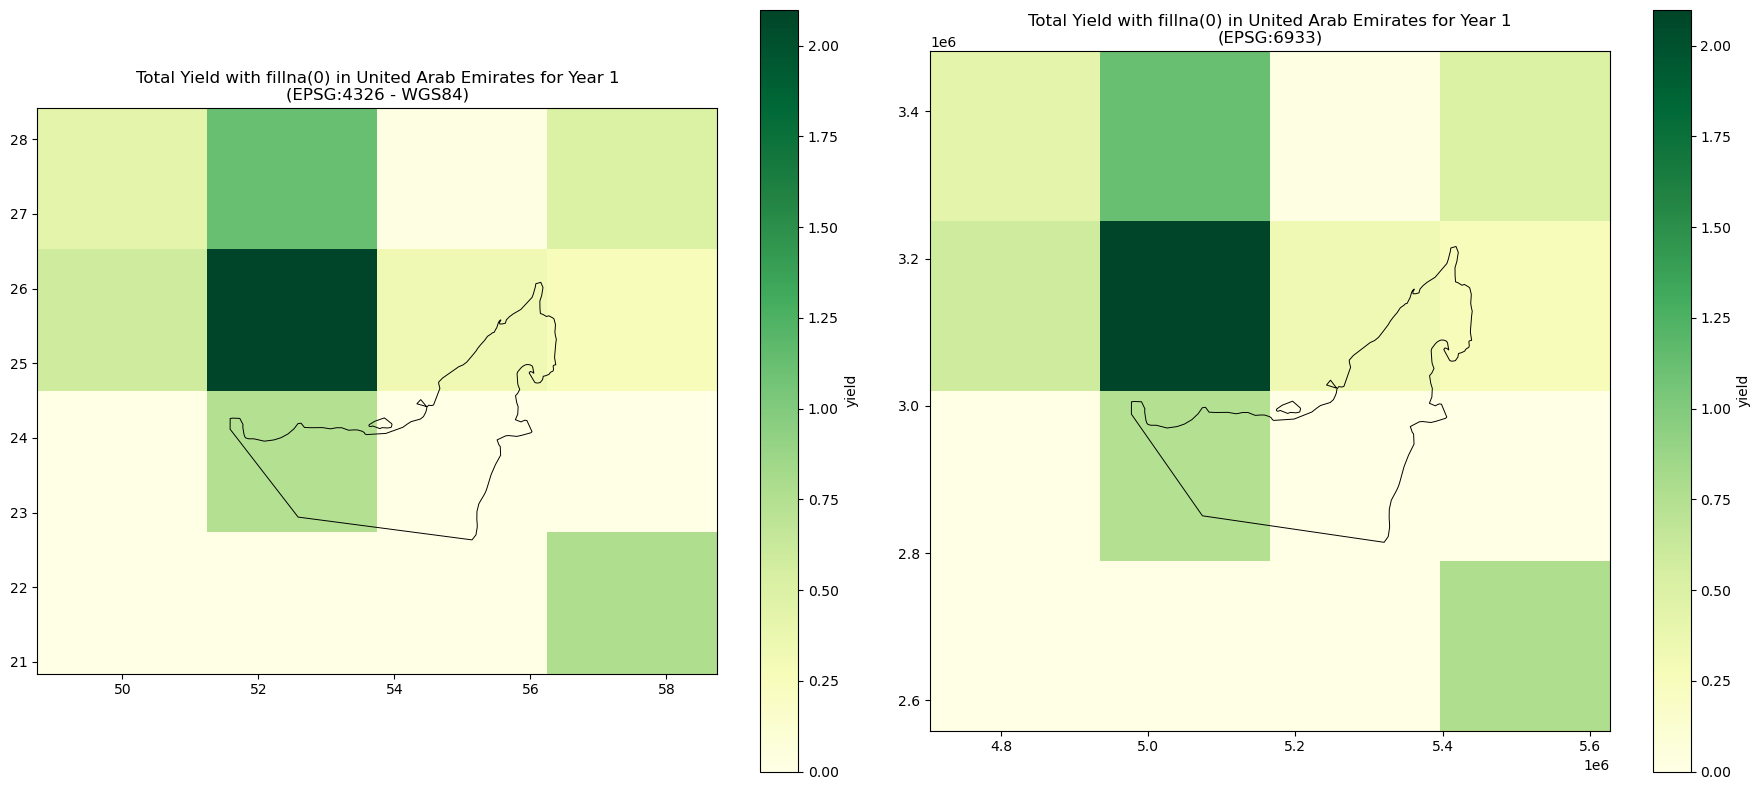

In [10]:
def assign_crs(data_array, epsg_code):
    # Check if 'lat' coordinate exists
    if 'lat' not in data_array.coords:
        raise KeyError("Missing 'lat' coordinate.")

    # Extract latitude values
    lat = data_array['lat']
    min_lat = lat.min().item()
    max_lat = lat.max().item()

    # Validate latitude values, including exact poles
    if min_lat <= -90 or max_lat >= 90:
        # Clip latitude values to the valid range, excluding exact poles
        data_array = data_array.where((lat > -90) & (lat < 90), drop=True)
        lat = data_array['lat']
        min_lat = lat.min().item()
        max_lat = lat.max().item()
        # Re-check latitude after clipping
        if min_lat <= -90 or max_lat >= 90:
            raise ValueError("Data contains invalid latitude values even after clipping.")

    # Verify spatial dimensions
    dims = data_array.dims
    # Ensure 'lat' and 'lon' are dimensions
    if 'lat' not in dims or 'lon' not in dims:
        raise ValueError("'lat' and/or 'lon' are not dimensions of the DataArray.")

    # Proceed with CRS assignment
    data_array = (
        data_array.rio.write_crs("EPSG:4326")  # Assuming original CRS is WGS84
        .rio.set_spatial_dims(x_dim='lon', y_dim='lat')
        .rio.reproject(f"EPSG:{epsg_code}")
    )

    return data_array

# Ensure rioxarray is imported
import rioxarray

# Reproject the raster data to EPSG:4326 (should already be in this CRS, but ensures CRS is assigned)
total_yield_with_fillna_year_4326 = assign_crs(total_yield_with_fillna_year, 4326)

# Reproject the raster data to EPSG:6933
total_yield_epsg6933 = assign_crs(total_yield_with_fillna_year, 6933)

# Reproject the country polygon to EPSG:6933
country_epsg6933 = country.to_crs(epsg=6933)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot in EPSG:4326
ax1 = axs[0]
im1 = total_yield_with_fillna_year_4326.plot(
    ax=ax1,
    cmap='YlGn',
    add_colorbar=True
)
country.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.7)
ax1.set_title(f'Total Yield with fillna(0) in {country_name} for Year 1\n(EPSG:4326 - WGS84)')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot in EPSG:6933
ax2 = axs[1]
im2 = total_yield_epsg6933.plot(
    ax=ax2,
    cmap='YlGn',
    add_colorbar=True
)
country_epsg6933.boundary.plot(ax=ax2, edgecolor='black', linewidth=0.7)
ax2.set_title(f'Total Yield with fillna(0) in {country_name} for Year 1\n(EPSG:6933)')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


## Touching pixels

When we clip the pixels that overlap with our country-level polygons, we have a choice abotu whether to include every pixel that barely touches the polygon or not. This too changes the yield calculations. After comparing the $R^2$ of my code's output with the reference file and the mean average percentage differences, it appears using `all_touched=True` yielded closer correspondence to the reference file, so I opted for that, which makes sense given that otherwise, some countries would have no fully overlapping pixels, given the raster resolution.

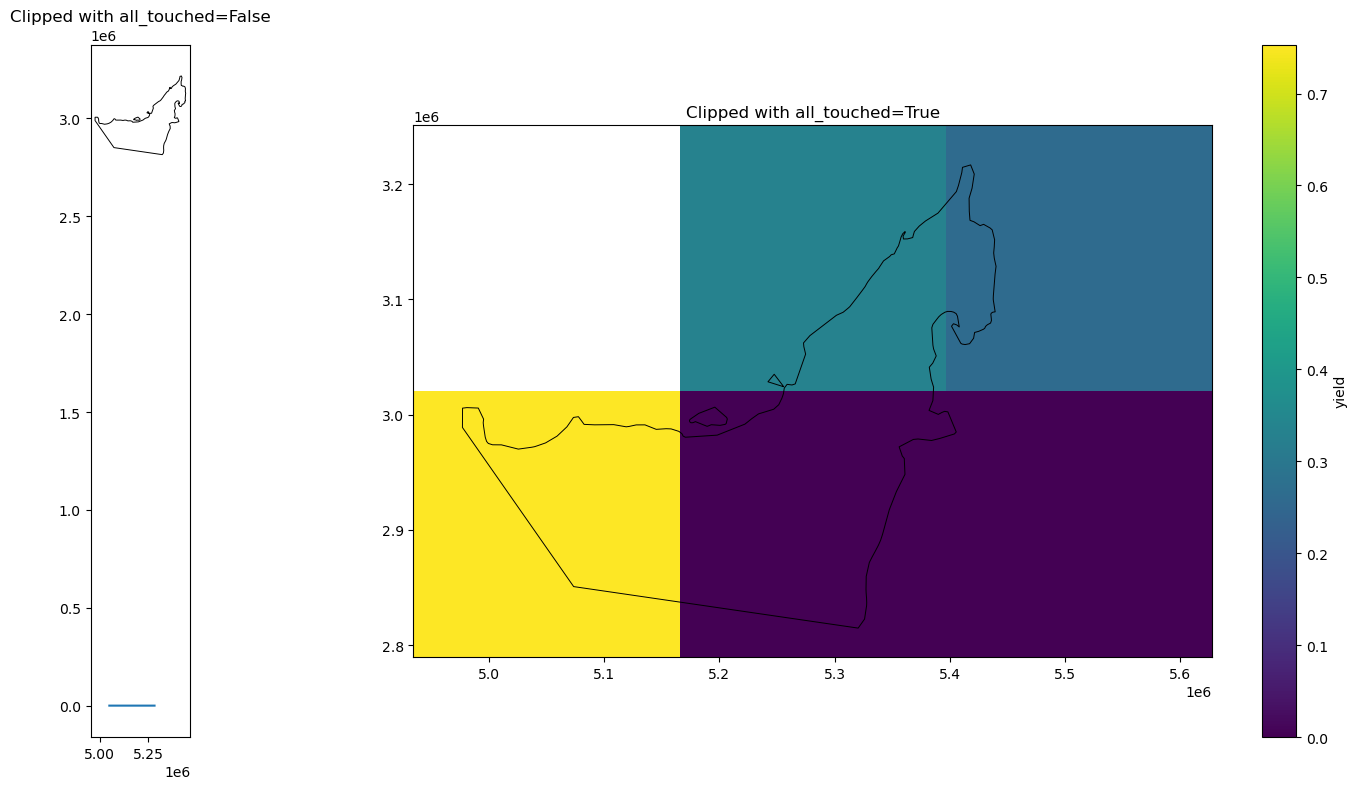

In [14]:
# Import the mapping function from shapely
from shapely.geometry import mapping

# Clip the raster data with all_touched=False (default behavior)
clipped_false = total_yield_epsg6933.rio.clip(
    country_epsg6933.geometry.apply(mapping),
    crs=country_epsg6933.crs,
    all_touched=False
)

# Clip the raster data with all_touched=True
clipped_true = total_yield_epsg6933.rio.clip(
    country_epsg6933.geometry.apply(mapping),
    crs=country_epsg6933.crs,
    all_touched=True
)

# Plot side by side to compare the effects
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot with all_touched=False
ax1 = axs[0]
clipped_false.plot(
    ax=ax1,
)
country_epsg6933.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.7)
ax1.set_title(f'Clipped with all_touched=False')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot with all_touched=True
ax2 = axs[1]
clipped_true.plot(
    ax=ax2,
)
country_epsg6933.boundary.plot(ax=ax2, edgecolor='black', linewidth=0.7)
ax2.set_title(f'Clipped with all_touched=True')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


After identifying the overlapping pixels in my code, my procedure is simple: I simply add up over all overlapping pixels for an estimate of total yield. This is likely to induce errors, particularly for smaller countries. It could be addressed via downscaling the pixels, as I demonstrate below

Original resolution: 1.894735336303711 degrees latitude, 2.5 degrees longitude
New resolution: 0.01894735336303711 degrees latitude, 0.025 degrees longitude


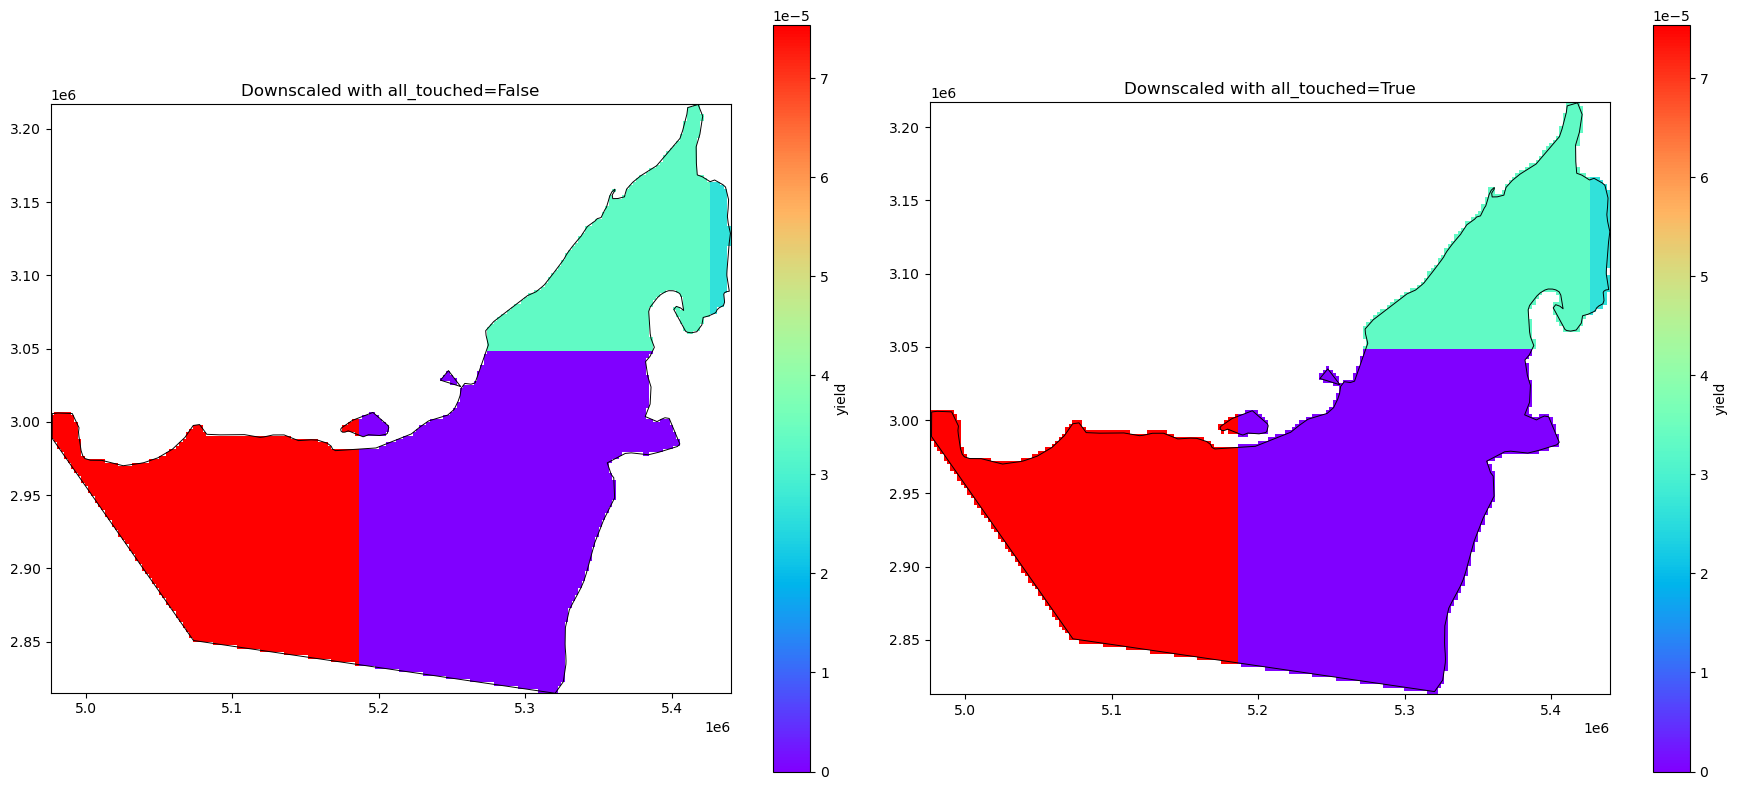

In [17]:
# Import necessary libraries
import numpy as np
import rioxarray
from rasterio.enums import Resampling
from shapely.geometry import mapping
import matplotlib.pyplot as plt

# Ensure that the 'total_yield_with_fillna' and 'country' variables are available from previous code blocks.

# Step 0: Extract the yield data for year 1 (index 0) and remove 'time' dimension
total_yield_with_fillna_year = total_yield_with_fillna.isel(time=0).squeeze()

# Step 1: Assign CRS and set spatial dimensions to the raster data
total_yield_with_fillna_year = total_yield_with_fillna_year.rio.write_crs("EPSG:4326")
total_yield_with_fillna_year = total_yield_with_fillna_year.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

# Step 2: Get current resolution
lat = total_yield_with_fillna_year['lat'].values
lon = total_yield_with_fillna_year['lon'].values

delta_lat = np.abs(lat[1] - lat[0])
delta_lon = np.abs(lon[1] - lon[0])

print(f"Original resolution: {delta_lat} degrees latitude, {delta_lon} degrees longitude")

# Step 3: Calculate new resolution (divide by 100)
factor = 100  # Downscaling factor
new_delta_lat = delta_lat / factor
new_delta_lon = delta_lon / factor

print(f"New resolution: {new_delta_lat} degrees latitude, {new_delta_lon} degrees longitude")

# Step 4: Downscale the raster data
downscaled = total_yield_with_fillna_year.rio.reproject(
    dst_crs="EPSG:4326",
    resolution=(new_delta_lon, new_delta_lat),
    resampling=Resampling.nearest
)

# Step 5: Divide the pixel values by 10000
downscaled = downscaled / (factor * factor)  # Dividing by 10000

# Step 6: Reproject the downscaled raster to EPSG:6933
downscaled_epsg6933 = downscaled.rio.reproject("EPSG:6933")

# Step 7: Reproject the country polygon to EPSG:6933
country_epsg6933 = country.to_crs(epsg=6933)

# Step 8: Clip the downscaled raster with all_touched=False
clipped_downscaled_false = downscaled_epsg6933.rio.clip(
    country_epsg6933.geometry.apply(mapping),
    crs=country_epsg6933.crs,
    all_touched=False
)

# Step 9: Clip the downscaled raster with all_touched=True
clipped_downscaled_true = downscaled_epsg6933.rio.clip(
    country_epsg6933.geometry.apply(mapping),
    crs=country_epsg6933.crs,
    all_touched=True
)

# Step 10: Plot the results
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot clipped_downscaled_false
ax1 = axs[0]
clipped_downscaled_false.plot(
    ax=ax1,
    cmap='rainbow',
    add_colorbar=True
)
country_epsg6933.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.7)
ax1.set_title(f'Downscaled with all_touched=False')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot clipped_downscaled_true
ax2 = axs[1]
clipped_downscaled_true.plot(
    ax=ax2,
    cmap='rainbow',
    add_colorbar=True
)
country_epsg6933.boundary.plot(ax=ax2, edgecolor='black', linewidth=0.7)
ax2.set_title(f'Downscaled with all_touched=True')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


However, I wasn't able to create an efficient version of the code that could downscale the raster and run in a reasonable amount of time. This could be addressed in future work. I also attempted a version of this code that used `rasterstats` `zonal_statistics` to try and calculated the sum, accounting for the fraction of pixel overlap, but this didn't yield any improvement in median $R^2$ or MAD of percentage point agreement with the reference output file.